In [1]:
#pip install torch torchvision torchaudio

In [2]:
#pip -q install torchxrayvision

In [3]:
#%env CUDA_VISIBLE_DEVICES=2

import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import time
from torchsummary import summary
import torchxrayvision as xrv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
from sklearn.model_selection import train_test_split
from PIL import Image

##Baixando dados

In [4]:
!git clone https://github.com/ieee8023/covid-chestxray-dataset

fatal: destination path 'covid-chestxray-dataset' already exists and is not an empty directory.


In [5]:
data = xrv.datasets.COVID19_Dataset(imgpath="covid-chestxray-dataset/images/",csvpath="covid-chestxray-dataset/metadata.csv")

In [6]:
data

{'Aspergillosis': {np.float32(0.0): 534, np.float32(1.0): 1},
 'Aspiration': {np.float32(0.0): 534, np.float32(1.0): 1},
 'Bacterial': {np.float32(0.0): 487, np.float32(1.0): 48},
 'COVID-19': {np.float32(0.0): 193, np.float32(1.0): 342},
 'Chlamydophila': {np.float32(0.0): 534, np.float32(1.0): 1},
 'Fungal': {np.float32(0.0): 512, np.float32(1.0): 23},
 'H1N1': {np.float32(0.0): 534, np.float32(1.0): 1},
 'Herpes ': {np.float32(0.0): 532, np.float32(1.0): 3},
 'Influenza': {np.float32(0.0): 531, np.float32(1.0): 4},
 'Klebsiella': {np.float32(0.0): 526, np.float32(1.0): 9},
 'Legionella': {np.float32(0.0): 526, np.float32(1.0): 9},
 'Lipoid': {np.float32(0.0): 527, np.float32(1.0): 8},
 'MERS-CoV': {np.float32(0.0): 527, np.float32(1.0): 8},
 'MRSA': {np.float32(0.0): 534, np.float32(1.0): 1},
 'Mycoplasma': {np.float32(0.0): 530, np.float32(1.0): 5},
 'No Finding': {np.float32(0.0): 520, np.float32(1.0): 15},
 'Nocardia': {np.float32(0.0): 531, np.float32(1.0): 4},
 'Pneumocystis': 

COVID19_Dataset num_samples=535 views=['PA', 'AP'] data_aug=None

In [7]:
df = data.csv

In [8]:
labels = []
imgs = []

for i in range(len(data)):
    pd.Series(dict(zip(data.pathologies,data[i]["lab"])))
    labels.append(pd.Series(dict(zip(data.pathologies,data[i]["lab"]))))
    imgs.append(data[i]["img"])

labels = pd.DataFrame(labels)
imgs = [i[0] for i in imgs]

In [9]:
# prompt: encontrar casos onde todos os registros são 0

zeros = []
for index, row in labels.iterrows():
    if row.sum() == 0:
        zeros.append(index)
print(f"Indices where all records are zero: {zeros}")

Indices where all records are zero: []


In [10]:
labels = labels['COVID-19']

In [11]:
labels.value_counts()

COVID-19
1.0    342
0.0    193
Name: count, dtype: int64

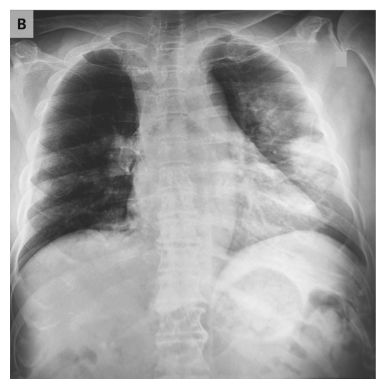

In [13]:
plt.imshow(imgs[1], cmap='gray')
plt.axis('off')
plt.show()

In [15]:
label_map = {
    0: 'Non-COVID',
    1: 'COVID-19'
}

In [16]:
base_dir = 'chestxray'
for split in ['train', 'val', 'test']:
    for label in label_map.values():
        os.makedirs(os.path.join(base_dir, split, label), exist_ok=True)

In [17]:
X_temp, X_test, y_temp, y_test = train_test_split(imgs, labels, test_size=0.15, stratify=labels, random_state=12)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.12, stratify=y_temp, random_state=33)

In [18]:
def save_images(img_list, label_list, split):
    for i, (img, label) in enumerate(zip(img_list, label_list)):
        folder = os.path.join(base_dir, split, label_map[label])

        # Se for numpy array float, converte para uint8 [0-255]
        if isinstance(img, np.ndarray):
            if img.dtype != np.uint8:
                img = (img * 255).astype(np.uint8)
            img = Image.fromarray(img)

        # Se for imagem PIL, mas em modo float, converte para RGB (ou L, dependendo do caso)
        elif img.mode == 'F':
            img = img.convert('RGB')  # ou 'L' para grayscale

        img.save(os.path.join(folder, f"{split}_{i}.png"))

In [19]:
save_images(X_train, y_train, 'train')
save_images(X_val, y_val, 'val')
save_images(X_test, y_test, 'test')

##Funções gerais

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
# Applying Transforms to the Data
# pre-trained models expect data with the same pre processing as data it was originally trained on
# thus those transformations are necessary
# + a bit of data augmentation
# podem resizes de tamanhos diferentes?
image_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=3), #xrays are b&w but densenet expects rgb
        transforms.RandomResizedCrop(size=332, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        #transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(), #image (format PIL) -> tensor (format pytorch)
        #normalizar por 255 - ToTensor já faz isso automatico
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    #val and test's transformations are deterministic (no noise, no diversity generated)
    'val': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(size=224),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [15]:
# Load the Data

# os.makedirs('chestxray/train/Non-COVID', exist_ok=True)
# os.makedirs('chestxray/train/COVID-19', exist_ok=True)

# os.makedirs('chestxray/val/Non-COVID', exist_ok=True)
# os.makedirs('chestxray/val/COVID-19', exist_ok=True)

# os.makedirs('chestxray/test/Non-COVID', exist_ok=True)
# os.makedirs('chestxray/test/COVID-19', exist_ok=True)

# Set train and valid directory paths
dataset = 'chestxray'
train_directory = os.path.join(dataset, 'train') #chestxray/train
val_directory = os.path.join(dataset, 'val') #chestxray/val
test_directory = os.path.join(dataset, 'test') #chestxray/test

#needed: #chestxray/train/covid
         #chestxray/train/noncovid
         #chestxray/val/covid
         #chestxray/val/noncovid
         #chestxray/test/covid
         #chestxray/test/noncovid

# Number of classes
num_classes = len(os.listdir(train_directory)) #num classes = num folds in each set fold

# Load Data from folders and apply transformations we set
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'val': datasets.ImageFolder(root=val_directory, transform=image_transforms['val']),
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
# ImageFolder creates mapping {class name: number}
# here the opposite is done: {number : class name} so we know the class outputted by its associated index
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
val_data_size = len(data['val'])
test_data_size = len(data['test'])
print(train_data_size, val_data_size, test_data_size)

# Create iterators for the Data loaded using DataLoader module
# batch generators
train_data_loader = DataLoader(data['train'], batch_size=32, shuffle=True) #not learning sequences here
val_data_loader = DataLoader(data['val'], batch_size=20, shuffle=False)
test_data_loader = DataLoader(data['test'], batch_size=20, shuffle=False)

{0: 'COVID-19', 1: 'Non-COVID'}
399 55 81


In [16]:
def train_and_validate(model, loss_criterion, optimizer, epochs, dataset="chestxraytry",
                       train_data_loader=train_data_loader, val_data_loader=val_data_loader, train_data_size=train_data_size,
                       val_data_size=val_data_size, device=device):

    start = time.time()
    history = []
    best_loss = 100000.0
    best_epoch = None

    #first: looping through training
    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        # Set to training mode -> activates dropout, batch norm, early stopping
        model.train()

        # Loss and Accuracy and Recall within the epoch
        train_loss = 0.0
        train_acc = 0.0
        valid_loss = 0.0
        valid_acc = 0.0
        valid_true_positives = 0.0
        valid_false_negatives = 0.0

        #for each batch
        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Clean existing gradients
            optimizer.zero_grad()

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Backpropagate the gradients
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Compute the total loss for the batch and add it to train_loss
            # loss.item() returns average loss for the batch,
            # so we multiply by batch size to get an estimation of the sum for the batch
            #(so we can obtain the average loss over the whole dataset later)
            train_loss += loss.item() * inputs.size(0)

            # Compute the accuracy
            _, predictions = torch.max(outputs.data, 1) #returns index of most probable class for each instance - the actual predictions for each batch instance
            correct_counts = predictions.eq(labels.data.view_as(predictions)) #compares predictions with labels resulting in a bool tensor (1 if right, 0 if not)
            acc = torch.mean(correct_counts.type(torch.FloatTensor)) #convert correct_counts to float and then compute the mean (fraction of sucesses in the batch)
            train_acc += acc.item() * inputs.size(0) #multiply this mean by batch size to evaluate the total accuracy later
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))


        # Validation - no gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode -> dropout off, batch norm fixed
            model.eval()

            # for each validation batch -> similar logic
            for j, (inputs, labels) in enumerate(val_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                _, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                valid_acc += acc.item() * inputs.size(0)
                valid_true_positives += ((predictions == 1) & (labels == 1)).sum().item() #total of true positives
                valid_false_negatives += ((predictions == 0) & (labels == 1)).sum().item() #total of false negatives
                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

        # is this the best model based on tinniest validation loss?
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_epoch = epoch

        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size
        avg_train_acc = train_acc/train_data_size
        avg_valid_loss = valid_loss/val_data_size
        avg_valid_acc = valid_acc/val_data_size
        valid_recall = valid_true_positives / (valid_true_positives + valid_false_negatives + 1e-7) #avoids 0 division
        #scheduler.step(avg_valid_loss)

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc, valid_recall])
        epoch_end = time.time()
        print("Epoch : {:03d}, Training: Loss - {:.4f}, Accuracy - {:.4f}%, \n\t\tValidation : Loss - {:.4f}, Accuracy - {:.4f}%, Recall - {:.4f}, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, valid_recall, epoch_end-epoch_start))

        # Save if the model has best accuracy till now
        torch.save(model, dataset+'_model_'+str(epoch)+'.pt')

    return model, history, best_epoch

In [17]:
def computeTestSetPerformance(model, loss_criterion, device):
    # Function to compute the accuracy on the test set

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    test_acc = 0.0
    test_loss = 0.0
    test_true_positives = 0.0
    test_false_negatives = 0.0

    # Validation - No gradient tracking needed
    with torch.no_grad():

        # Set to evaluation mode
        model.eval()

        # for each batch in test
        for j, (inputs, labels) in enumerate(test_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Compute the total loss for the batch and add it to valid_loss
            test_loss += loss.item() * inputs.size(0)
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            test_acc += acc.item() * inputs.size(0)
            test_true_positives += ((predictions == 1) & (labels == 1)).sum().item()
            test_false_negatives += ((predictions == 0) & (labels == 1)).sum().item()

            print("Test Batch number: {:03d}, Test: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

    # Find average test loss and test accuracy and recall
    avg_test_loss = test_loss/test_data_size
    avg_test_acc = test_acc/test_data_size
    test_recall = test_true_positives / (test_true_positives + test_false_negatives + 1e-7)

    print("Test accuracy : " + str(avg_test_acc))


In [28]:
def predict(model, test_image_name):
    #Function to predict the class of a single test image

    transform = image_transforms['test'] #loads pre processing needed into test images in 'transform' object
    test_image = Image.open(test_image_name)
    plt.imshow(test_image)
    test_image_tensor = transform(test_image) #applies the processing

    if torch.cuda.is_available():
      #view regorganized tensor so its format is (batch size X number of channels X height X depth)
        #test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
        #unsqueeze(dim) adds dimension of size 1 at position dim
        test_image_tensor = test_image_tensor.unsqueeze(0).cuda()
    else:
        #test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
        test_image_tensor = test_image_tensor.unsqueeze(0)

    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor) #model outputs (probabilities for each class)
        #ps = torch.exp(out) #for LogSoftMax activation

        topk, topclass = out.topk(1, dim=1) #most likely class
        cls = idx_to_class[topclass.cpu().numpy()[0][0]]
        score = topk.cpu().numpy()[0][0]
        print("Prediction:", cls, ", with probability:", score) #shows most likely class

shufflenet

In [34]:
print(shufflenet)

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_

In [111]:
shufflenet = models.shufflenet_v2_x1_0(weights=models.ShuffleNet_V2_X1_0_Weights.DEFAULT)

In [112]:
num_features = shufflenet.fc.in_features
shufflenet.fc = nn.Linear(num_features, 2)

In [113]:
for param in shufflenet.parameters():
    param.requires_grad = False  

for param in shufflenet.fc.parameters():
    param.requires_grad = True 

for param in shufflenet.stage4.parameters():
    param.requires_grad = True

for param in shufflenet.stage3[-2:].parameters():
    param.requires_grad = True

In [131]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam([p for p in shufflenet.parameters() if p.requires_grad], lr=3e-4)

In [ ]:
num_epochs = 33
trained_model, history, best_epoch = train_and_validate(shufflenet, loss_func, optimizer, num_epochs)

Epoch: 1/33
Epoch : 000, Training: Loss - 0.2542, Accuracy - 93.4837%, 
		Validation : Loss - 1.2909, Accuracy - 58.1818%, Recall - 0.2500, Time: 50.9560s
Epoch: 2/33
Epoch : 001, Training: Loss - 0.2226, Accuracy - 92.7318%, 
		Validation : Loss - 1.1275, Accuracy - 52.7273%, Recall - 0.3000, Time: 57.5164s
Epoch: 3/33


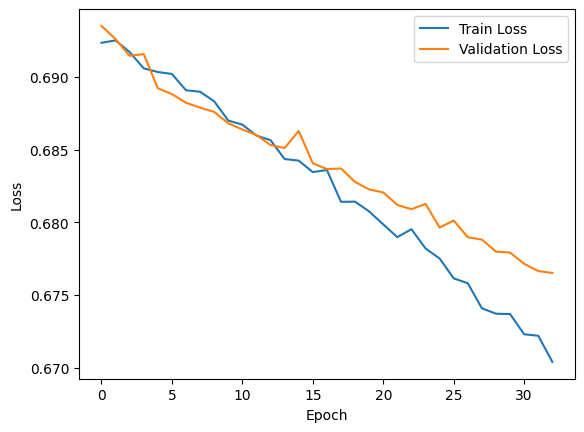

In [117]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Train Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

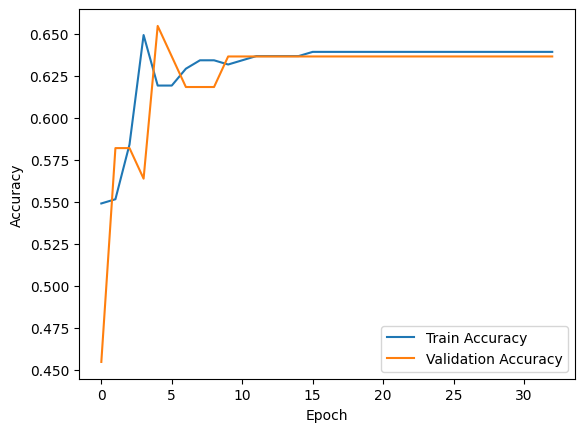

In [118]:
plt.plot(history[:,2:4])
plt.legend(['Train Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

googlenet

In [18]:
googlenet = models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT)

In [19]:
print(googlenet)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [20]:
num_features = googlenet.fc.in_features
googlenet.fc = nn.Linear(num_features, 2)

In [21]:
for param in googlenet.parameters():
    param.requires_grad = False

In [22]:
for param in googlenet.fc.parameters():
    param.requires_grad = True

for param in googlenet.inception5b.branch4.parameters():
    param.requires_grad = True

In [24]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam([p for p in googlenet.parameters() if p.requires_grad], lr=9e-4)

In [25]:
num_epochs = 15
trained_model, history, best_epoch = train_and_validate(googlenet, loss_func, optimizer, num_epochs)

Epoch: 1/15
Epoch : 000, Training: Loss - 0.6937, Accuracy - 61.9048%, 
		Validation : Loss - 0.6628, Accuracy - 63.6364%, Recall - 0.0000, Time: 44.4572s
Epoch: 2/15
Epoch : 001, Training: Loss - 0.6461, Accuracy - 65.6642%, 
		Validation : Loss - 0.6671, Accuracy - 61.8182%, Recall - 0.0000, Time: 42.9884s
Epoch: 3/15
Epoch : 002, Training: Loss - 0.6162, Accuracy - 65.6642%, 
		Validation : Loss - 0.6731, Accuracy - 61.8182%, Recall - 0.0000, Time: 48.9051s
Epoch: 4/15
Epoch : 003, Training: Loss - 0.5976, Accuracy - 70.1754%, 
		Validation : Loss - 0.6731, Accuracy - 58.1818%, Recall - 0.0500, Time: 40.0012s
Epoch: 5/15
Epoch : 004, Training: Loss - 0.6002, Accuracy - 65.4135%, 
		Validation : Loss - 0.6864, Accuracy - 54.5455%, Recall - 0.2000, Time: 39.2398s
Epoch: 6/15
Epoch : 005, Training: Loss - 0.5661, Accuracy - 69.1729%, 
		Validation : Loss - 0.7005, Accuracy - 61.8182%, Recall - 0.0500, Time: 38.6761s
Epoch: 7/15
Epoch : 006, Training: Loss - 0.5875, Accuracy - 68.6717%,

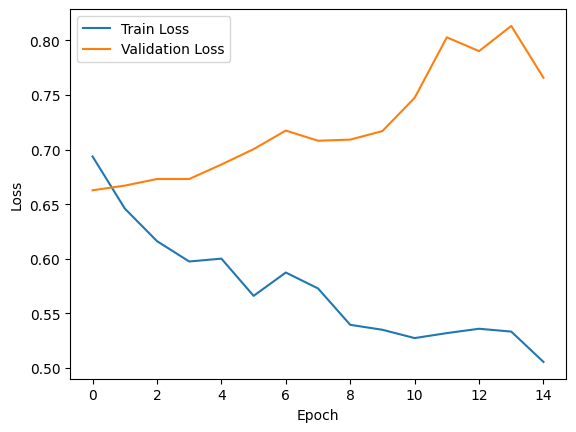

In [26]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Train Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

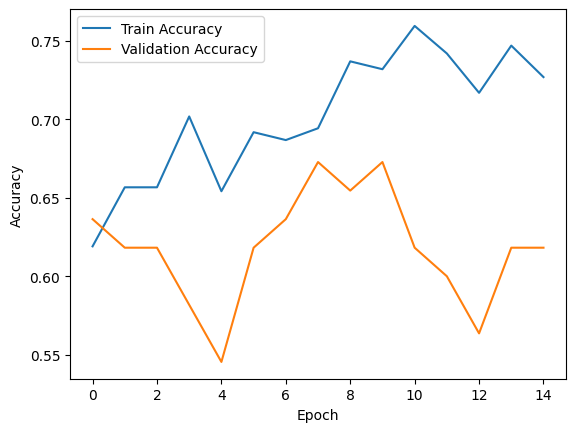

In [27]:
plt.plot(history[:,2:4])
plt.legend(['Train Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()